In [24]:
import sys
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import scipy

# suppress warning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

sys.path.append('../')
from envir import config

In [25]:
# read in files
files = ['KOKX2016night.csv', 'KOKX2017night.csv',
         'KOKX2018night.csv', 'KOKX2019night.csv']
kokx = pd.DataFrame()
for f in files:
    temp = pd.read_csv(config.dataFol+'clean_nexrad/'+f)
    kokx = kokx.append(temp)

In [26]:
kokx['year'] = pd.DatetimeIndex(kokx['datetime']).year
kokx['month'] = pd.DatetimeIndex(kokx['datetime']).month
kokx['day'] = pd.DatetimeIndex(kokx['datetime']).day
kokx['hour'] = pd.DatetimeIndex(kokx['datetime']).hour
kokx['minute'] = pd.DatetimeIndex(kokx['datetime']).minute
kokx['date'] = pd.to_datetime(kokx.year*10000+kokx.month*100+kokx.day,format='%Y%m%d')
kokx['datetime'] = pd.to_datetime(kokx.datetime)
kokx.set_index(kokx.datetime, inplace=True)

In [27]:
kokx.head(2)

,datetime,mtr,vid,vir,rtr,mt,rt,ff,dd,u,...,airspeed,heading,airspeed_u,airspeed_v,year,month,day,hour,minute,date
datetime,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:01:23,2016-01-01 00:01:23,2.404765,0.100105,1.10116,26.452419,0.196389,2.160281,6.672867,120.481784,5.745748,...,2.245836,250.508740,-2.125352,-0.460421,2016,1,1,0,1,2016-01-01
2016-01-01 00:11:11,2016-01-01 00:11:11,2.401061,0.087945,0.96739,26.411676,0.587562,6.463183,7.583887,109.591163,7.109099,...,1.218308,23.347845,-0.425245,0.419093,2016,1,1,0,11,2016-01-01


In [28]:
kokx.describe()

,mtr,vid,vir,rtr,mt,rt,ff,dd,u,v,height,airspeed,heading,airspeed_u,airspeed_v,year,month,day,hour,minute
count,119750.000000,119750.000000,119750.000000,119750.000000,1.197500e+05,1.197500e+05,119750.000000,119750.000000,119750.000000,119750.000000,119750.000000,119750.000000,119750.000000,119750.000000,119750.000000,119750.000000,119750.000000,119750.000000,119750.000000,119750.000000
mean,270.091712,7.336920,80.706125,2971.008833,5.454709e+05,6.000180e+06,9.117920,100.236319,2.638886,0.254255,441.148054,4.889732,95.545896,-0.290222,0.113669,2017.376459,6.250889,15.625987,6.457111,29.489445
std,1140.182465,26.046976,286.516738,12542.007114,5.342596e+05,5.876856e+06,4.432591,87.697396,6.821399,6.414607,249.648436,3.188288,83.391268,4.167966,3.425167,1.066777,3.534317,8.803057,5.832892,17.307287
min,0.000000,0.006926,0.076190,0.000000,1.706356e-01,1.876991e+00,0.000000,-89.996494,-64.601200,-77.885743,115.597081,0.000000,-87.959793,-63.029303,-74.893681,2016.000000,1.000000,1.000000,0.000000,0.000000
25%,9.504372,0.305385,3.359235,104.548097,8.583535e+04,9.441889e+05,6.090128,43.931241,-2.337756,-4.197266,246.843949,2.755911,31.135675,-2.426411,-1.893415,2016.000000,3.000000,8.000000,2.000000,15.000000
50%,32.316562,1.141305,12.554355,355.482187,4.259954e+05,4.685950e+06,8.395274,88.749895,3.144089,0.083342,375.315036,4.093918,91.985295,-0.213193,0.005452,2017.000000,6.000000,16.000000,5.000000,30.000000
75%,115.540672,4.296187,47.258057,1270.947393,8.160414e+05,8.976455e+06,11.365944,171.547896,7.438281,4.324366,581.321660,6.221649,163.152480,1.945909,1.910873,2018.000000,9.000000,23.000000,8.000000,44.000000
max,39141.509595,698.591324,7684.504560,430556.605550,1.781220e+06,1.959342e+07,77.950915,269.998606,52.021801,70.475318,2380.664937,78.117941,267.505523,53.686144,71.664854,2019.000000,12.000000,31.000000,23.000000,59.000000


In [29]:
# scans per year
kokx.groupby(['year']).count()['mtr']

year
2016    32311
2017    31819
2018    33848
2019    21772
Name: mtr, dtype: int64

Text(0, 0.5, 'mtr')

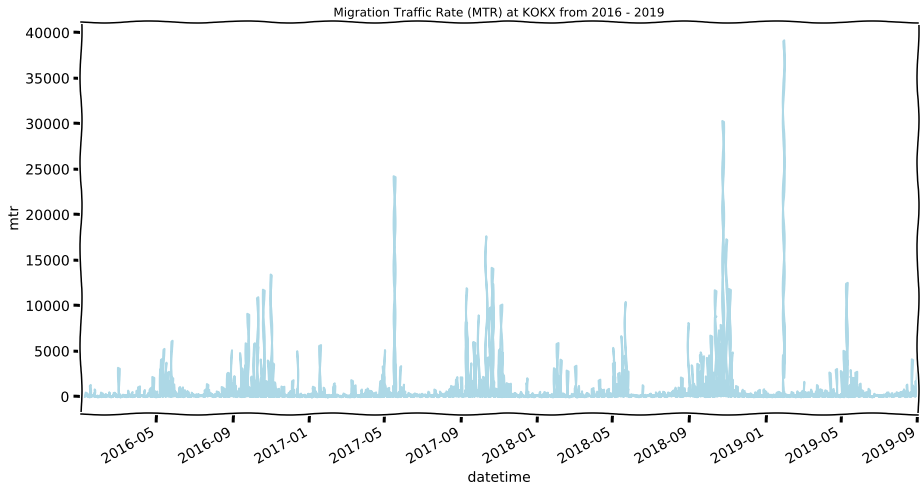

In [30]:
plt.xkcd()
kokx['mtr'].plot(color='lightblue', figsize=(15, 8))
plt.title('Migration Traffic Rate (MTR) at KOKX from 2016 - 2019', fontsize=12)
plt.ylabel('mtr')

In [31]:
kokx.groupby(['year', 'month', 'day']).mean()['mtr']

year  month  day
2016  1      1         8.193062
             2         7.361410
             3         7.360775
             4         6.467369
             5         9.348730
                       ...     
2019  8      28       19.745157
             29       64.293513
             30      864.152626
             31      389.050195
      9      1      1598.399594
Name: mtr, Length: 1335, dtype: float64

Text(0, 0.5, 'mtr')

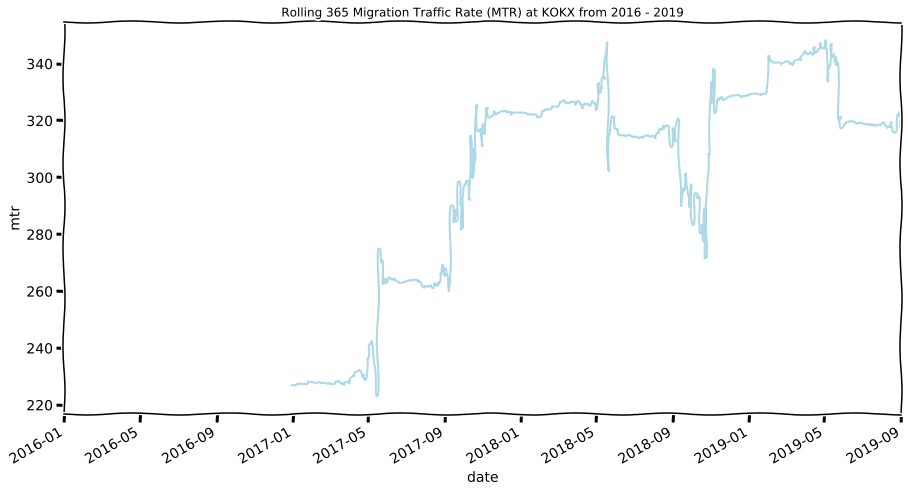

In [32]:
kokx.groupby(['date']).mean()['mtr'].rolling(window = 365).mean().plot(color='lightblue', figsize=(15, 8))
plt.title('Rolling 365 Migration Traffic Rate (MTR) at KOKX from 2016 - 2019', fontsize=12)
plt.ylabel('mtr')

In [33]:
kokx_by_day = kokx.groupby(['date']).mean()
pd.to_datetime(kokx_by_day.index).year


Int64Index([2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016,
            ...
            2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019],
           dtype='int64', name='date', length=1335)

In [34]:
kokx_by_day.head()


,mtr,vid,vir,rtr,mt,rt,ff,dd,u,v,height,airspeed,heading,airspeed_u,airspeed_v,year,month,day,hour,minute
date,,,,,,,,,,,,,,,,,,,,
2016-01-01,8.193062,0.276783,3.044610,90.123685,119.851910,1318.371015,9.544093,107.344943,8.393473,-3.002062,423.147838,3.319441,76.217134,0.882437,-0.271914,2016.0,1.0,1.0,8.488889,30.088889
2016-01-02,7.361410,0.243226,2.675488,80.975506,628.776211,6916.538324,9.621528,103.832067,8.958274,-2.263610,250.626700,3.015356,45.083581,0.443319,1.100700,2016.0,1.0,2.0,8.505618,29.179775
2016-01-03,7.360775,0.220056,2.420620,80.968521,1103.085043,12133.935473,10.037219,76.433910,8.959857,2.428207,258.790958,3.430985,55.062018,1.188527,1.591720,2016.0,1.0,3.0,8.373626,29.450549
2016-01-04,6.467369,0.204916,2.254076,71.141061,1634.800254,17982.802796,9.549238,130.637327,6.650512,-4.365889,449.205624,4.626807,80.661241,2.129256,0.896881,2016.0,1.0,4.0,8.411111,29.244444
2016-01-05,9.348730,0.301624,3.317864,102.836028,1913.086836,21043.955196,9.241114,191.492896,-1.810769,-8.106683,508.863340,4.647838,83.057955,-0.277411,0.386438,2016.0,1.0,5.0,8.314607,29.561798


In [35]:
kokx_by_month = kokx.groupby(['year', 'month']).mean()
kokx_by_month.reset_index().pivot(index='month', columns='year', values='mtr')


year,2016,2017,2018,2019
month,,,,
1,17.195982,37.951178,23.799138,223.287204
2,25.104380,13.287499,74.376530,30.198422
3,54.757759,46.662340,64.740378,93.971052
4,86.345946,192.153269,98.217535,124.742495
5,483.380814,905.287219,875.243025,523.354125
6,83.581409,86.498745,41.594739,47.027070
7,90.489563,68.841061,65.727899,62.664246
8,258.219117,255.441062,269.357843,256.936383
9,519.234928,886.381445,578.928854,1598.399594


In [36]:
import seaborn as sns
kokx_by_month.reset_index().head()


,year,month,mtr,vid,vir,rtr,mt,rt,ff,dd,u,v,height,airspeed,heading,airspeed_u,airspeed_v,day,hour,minute
0,2016,1,17.195982,0.425175,4.676926,189.155807,8523.051027,9.375356e+04,9.532840,106.901101,4.142245,-1.269271,363.754446,4.472596,69.335352,0.555688,0.627316,15.581875,8.352694,29.442267
1,2016,2,25.104380,0.639190,7.031090,276.148178,29865.221293,3.285174e+05,10.179797,91.108401,3.286983,1.866523,401.636783,4.157175,74.894790,0.371569,0.428881,14.518188,7.433310,29.562411
2,2016,3,54.757759,1.274785,14.022640,602.335345,56510.306424,6.216134e+05,9.984364,90.801213,3.985467,1.785156,393.672352,4.894013,72.507133,1.568875,1.428137,15.652252,6.588108,29.449730
3,2016,4,86.345946,2.070679,22.777467,949.805405,89867.389283,9.885413e+05,9.575672,94.110385,4.692348,2.474801,439.258396,4.865093,71.032187,1.782688,1.849969,14.913113,5.573210,29.713194
4,2016,5,483.380814,12.203494,134.238431,5317.188955,214013.479444,2.354148e+06,8.655666,83.001065,4.818890,2.684695,484.091582,5.408570,61.021228,2.829127,2.735371,17.129216,4.262812,29.136224


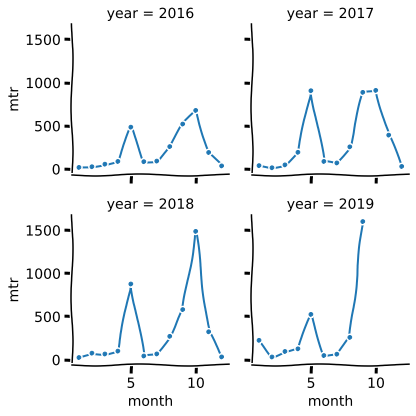

In [37]:
# annual patterns of mtr
g = sns.FacetGrid(kokx_by_month.reset_index(), col="year", col_wrap=2, height=3)
g = g.map(plt.plot, "month", "mtr", marker=".")

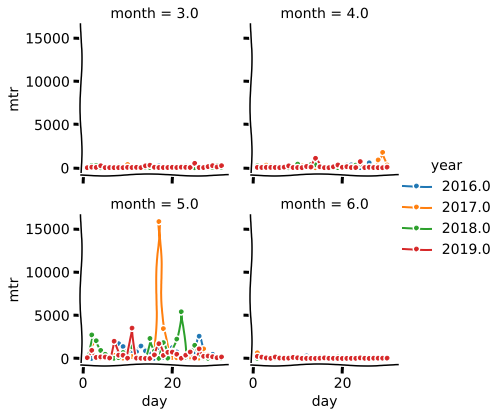

In [38]:
# annual patterns of mtr in March - June
g = sns.FacetGrid(kokx_by_day[(kokx_by_day['month']>=3) & (kokx_by_day['month']<=6)], hue="year",
                  col="month", col_wrap=2, height=3)
g = (g.map(plt.plot, "day", "mtr", marker=".").add_legend())

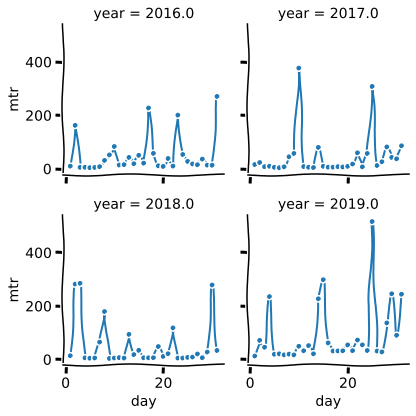

In [39]:
# annual patterns of mtr in March
g = sns.FacetGrid(kokx_by_day[kokx_by_day['month']==3], col="year", col_wrap=2, height=3)
g = g.map(plt.plot, "day", "mtr", marker=".")



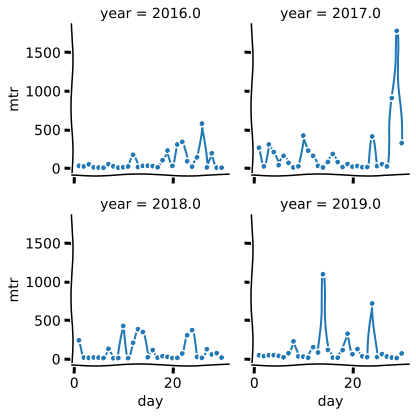

In [40]:
# annual patterns of mtr in April
g = sns.FacetGrid(kokx_by_day[kokx_by_day['month']==4], col="year", col_wrap=2, height=3)
g = g.map(plt.plot, "day", "mtr", marker=".")

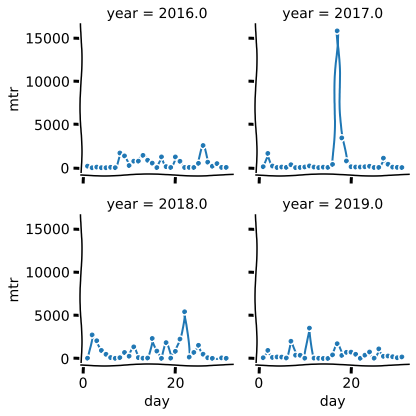

In [41]:
# annual patterns of mtr in May
g = sns.FacetGrid(kokx_by_day[kokx_by_day['month']==5], col="year", col_wrap=2, height=3)
g = g.map(plt.plot, "day", "mtr", marker=".")

In [42]:
dow = kokx_by_day.index.to_series()

In [43]:
kokx_by_day['day_of_week'] = dow.dt.dayofweek

In [44]:
kokx_by_day.head()

,mtr,vid,vir,rtr,mt,rt,ff,dd,u,v,...,airspeed,heading,airspeed_u,airspeed_v,year,month,day,hour,minute,day_of_week
date,,,,,,,,,,,,,,,,,,,,,
2016-01-01,8.193062,0.276783,3.044610,90.123685,119.851910,1318.371015,9.544093,107.344943,8.393473,-3.002062,...,3.319441,76.217134,0.882437,-0.271914,2016.0,1.0,1.0,8.488889,30.088889,4
2016-01-02,7.361410,0.243226,2.675488,80.975506,628.776211,6916.538324,9.621528,103.832067,8.958274,-2.263610,...,3.015356,45.083581,0.443319,1.100700,2016.0,1.0,2.0,8.505618,29.179775,5
2016-01-03,7.360775,0.220056,2.420620,80.968521,1103.085043,12133.935473,10.037219,76.433910,8.959857,2.428207,...,3.430985,55.062018,1.188527,1.591720,2016.0,1.0,3.0,8.373626,29.450549,6
2016-01-04,6.467369,0.204916,2.254076,71.141061,1634.800254,17982.802796,9.549238,130.637327,6.650512,-4.365889,...,4.626807,80.661241,2.129256,0.896881,2016.0,1.0,4.0,8.411111,29.244444,0
2016-01-05,9.348730,0.301624,3.317864,102.836028,1913.086836,21043.955196,9.241114,191.492896,-1.810769,-8.106683,...,4.647838,83.057955,-0.277411,0.386438,2016.0,1.0,5.0,8.314607,29.561798,1


### Deeper Look at By Hour By Height

#### Peaks in the month of May
Since the above line plots seem to demonstrate peaks in May for each year. Let's sample a couple of dates to look at both the mtr and the height metric for exploration.
##### Dates to Examine:
* May 26, 2016
* May 17, 2017
* May 22, 2018
* May 11, 2019

In [45]:
may_peaks = ['2016-05-26', '2017-05-17', '2018-05-22', '2019-05-11']
kokx_by_day[kokx_by_day.index.isin(may_peaks)]

,mtr,vid,vir,rtr,mt,rt,ff,dd,u,v,...,airspeed,heading,airspeed_u,airspeed_v,year,month,day,hour,minute,day_of_week
date,,,,,,,,,,,,,,,,,,,,,
2016-05-26,2572.452245,48.532598,533.858579,28296.974691,279012.315695,3.069135e+06,13.280132,58.418878,11.119588,6.965279,...,9.670248,35.408657,5.540201,7.655609,2016.0,5.0,26.0,4.298246,28.438596,3
2017-05-17,15805.835517,301.685595,3318.541549,173864.190682,259334.056666,2.852675e+06,14.360460,52.009979,11.273814,8.800308,...,10.689414,31.626251,5.859155,8.594608,2017.0,5.0,17.0,4.755319,29.670213,2
2018-05-22,5392.623663,116.677077,1283.447843,59318.860296,354187.356390,3.896061e+06,12.322686,55.804883,10.175485,6.793309,...,12.829745,44.953935,9.117302,8.536196,2018.0,5.0,22.0,4.494737,28.736842,1
2019-05-11,3504.684836,50.766739,558.434124,38551.533196,351869.692918,3.870567e+06,15.810575,81.517566,13.346553,5.407714,...,7.325614,69.093935,4.025192,3.953769,2019.0,5.0,11.0,4.594595,29.756757,5


In [46]:
kokx[kokx.date.isin(may_peaks)].groupby('date').count()

,datetime,mtr,vid,vir,rtr,mt,rt,ff,dd,u,...,height,airspeed,heading,airspeed_u,airspeed_v,year,month,day,hour,minute
date,,,,,,,,,,,,,,,,,,,,,
2016-05-26,57,57,57,57,57,57,57,57,57,57,...,57,57,57,57,57,57,57,57,57,57
2017-05-17,94,94,94,94,94,94,94,94,94,94,...,94,94,94,94,94,94,94,94,94,94
2018-05-22,95,95,95,95,95,95,95,95,95,95,...,95,95,95,95,95,95,95,95,95,95
2019-05-11,111,111,111,111,111,111,111,111,111,111,...,111,111,111,111,111,111,111,111,111,111


In [56]:
kokx.index.to_series().diff().mean()

Timedelta('0 days 00:16:06.407970')

2016-05-26
Average time in minutes between scans
0 days 00:09:44
2017-05-17
Average time in minutes between scans
0 days 00:05:03
2018-05-22
Average time in minutes between scans
0 days 00:05:06
2019-05-11
Average time in minutes between scans
0 days 00:05:09.500000


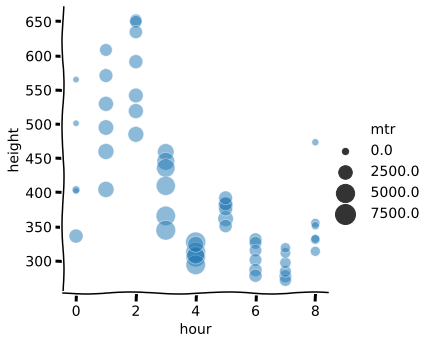

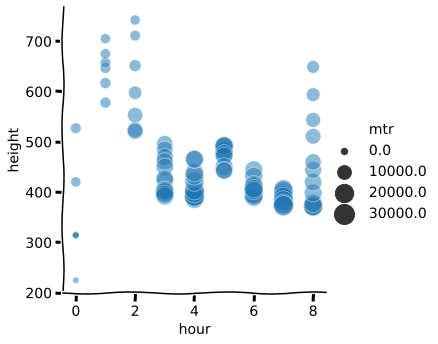

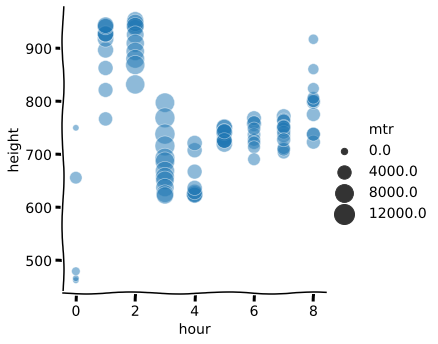

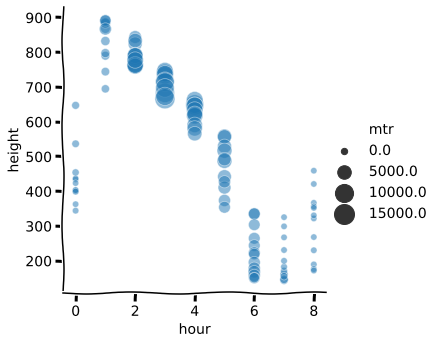

In [82]:
for i in may_peaks:
    print(i)
    print("Average time in minutes between scans")
    print(kokx[kokx.date.isin([i])].index.to_series().diff().median())
    sns.relplot(x='hour', y="height", size="mtr",
                sizes=(40, 400), alpha=.5, palette="muted",
                height=5, data=kokx[(kokx.date.isin([i])) & (kokx.hour <=8)])

2016-05-26
Average time in minutes between scans
0 days 00:09:44
2017-05-17
Average time in minutes between scans
0 days 00:05:03
2018-05-22
Average time in minutes between scans
0 days 00:05:06
2019-05-11
Average time in minutes between scans
0 days 00:05:09.500000


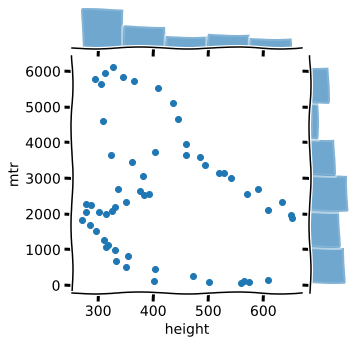

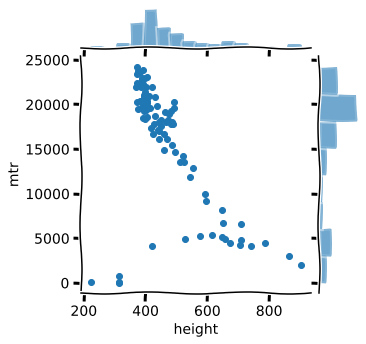

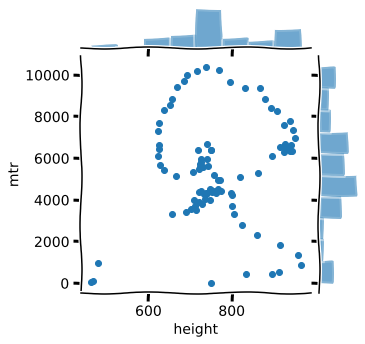

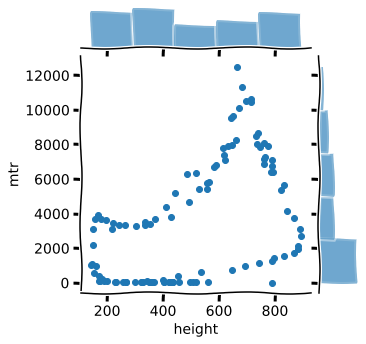

In [83]:
for i in may_peaks:
    print(i)
    print("Average time in minutes between scans")
    print(kokx[kokx.date.isin([i])].index.to_series().diff().median())
    sns.jointplot(x=kokx[(kokx.date.isin([i]))].height,
                  y=kokx[(kokx.date.isin([i]))].mtr,
                  kind='scatter', height=5 )

In [85]:
for i in may_peaks:
    print(i)
    print("Average time in minutes between scans")
    print(kokx[kokx.date.isin([i])].index.to_series().diff().median())
    print(kokx[kokx.date.isin([i])].index.to_series().diff().mean())
    print(kokx[kokx.date.isin([i])].index.to_series().diff().mode())


2016-05-26
Average time in minutes between scans
0 days 00:09:44
0 days 00:09:45.625000
0   00:09:44
dtype: timedelta64[ns]
2017-05-17
Average time in minutes between scans
0 days 00:05:03
0 days 00:06:04.473118
0   00:05:02
dtype: timedelta64[ns]
2018-05-22
Average time in minutes between scans
0 days 00:05:06
0 days 00:05:54.648936
0   00:05:06
dtype: timedelta64[ns]
2019-05-11
Average time in minutes between scans
0 days 00:05:09.500000
0 days 00:13:02.481818
0   00:05:08
dtype: timedelta64[ns]


In [92]:
for i in range(2016, 2020) :
    print(i)
    print("Average time in minutes between scans")
    print(kokx[kokx.date.isin([i])].index.to_series().diff().median())
    print(kokx[kokx.date.isin([i])].index.to_series().diff().mean())
    print(kokx[kokx.date.isin([i])].index.to_series().diff().mode())


2016
Average time in minutes between scans
NaT
NaT
Series([], dtype: timedelta64[ns])
2017
Average time in minutes between scans
NaT
NaT
Series([], dtype: timedelta64[ns])
2018
Average time in minutes between scans
NaT
NaT
Series([], dtype: timedelta64[ns])
2019
Average time in minutes between scans
NaT
NaT
Series([], dtype: timedelta64[ns])


In [101]:
kokx_by_year_standard = kokx[['year', 'mtr', 'height']].groupby('year').transform(lambda x: (x - x.mean()) / x.std())
kokx_by_year_standard.rename(columns = {'mtr':'mtr_standardized', 'height': 'height_standardized'}, inplace=True)

In [106]:
kokx = pd.concat([kokx, kokx_by_year_standard], axis=1)

In [ ]:
for i in range(2016, 2020):
    print(i)
    print("Average time in minutes between scans")
    print(kokx[kokx.year==i].index.to_series().diff().median())
    print(kokx[kokx.year==i].index.to_series().diff().mean())
    print(kokx[kokx.year==i].index.to_series().diff().mode())
    sns.relplot(x='hour', y="height_standardized", size="mtr_standardized",
                sizes=(40, 400), alpha=.5, palette="muted",
                height=5, data=kokx[(kokx.year==i) & (kokx.hour <=8) & (kokx.month.isin([3, 4, 5, 6]))])

2016
Average time in minutes between scans
0 days 00:09:43
0 days 00:16:18.468709
0   00:09:44
dtype: timedelta64[ns]
2017
Average time in minutes between scans
0 days 00:09:44
0 days 00:16:30.866867
0   00:09:48
dtype: timedelta64[ns]
2018
Average time in minutes between scans
0 days 00:07:12
0 days 00:15:31.467663
0   00:09:48
dtype: timedelta64[ns]
2019
Average time in minutes between scans
0 days 00:08:25
0 days 00:16:06.059023
0   00:09:47
dtype: timedelta64[ns]
